# Setup

## Root and data folders

In [2]:
import os
import pandas as pd
import numpy as np

root_dir = "/Users/silviumatu/Desktop/Code/Python/Disertatie/Disertatie_Matu_Silviu_v1"
os.makedirs(root_dir, exist_ok=True)

data_dir = os.path.join(root_dir, "Data")
os.makedirs(data_dir, exist_ok=True)

# Load data

In [3]:
EXP_reg_df = pd.read_csv(os.path.join(data_dir, "EXP_regression_data_forecast.csv"))
columns_EXP_reg_df = pd.read_csv(os.path.join(data_dir, "columns_EXP_regression_data_forecast_S.csv"))

EXP_reg_df.head()



n_rows = len(EXP_reg_df)
n_unique_participants = EXP_reg_df["x_participant_id"].nunique()


group_sizes = EXP_reg_df.groupby("x_participant_id").size()
avg_rows_per_id = group_sizes.mean()
min_rows_per_id = group_sizes.min()
max_rows_per_id = group_sizes.max()


avg_age_per_participant = (
    EXP_reg_df.groupby("x_participant_id")["x_age"].first().mean()
)



summary = {
    "n_rows": n_rows,
    "n_unique_participants": n_unique_participants,
    "avg_rows_per_participant": avg_rows_per_id,
    "min_rows_per_participant": min_rows_per_id,
    "max_rows_per_participant": max_rows_per_id,
    "avg_age_per_participant": avg_age_per_participant
}
summary

{'n_rows': 4429,
 'n_unique_participants': 137,
 'avg_rows_per_participant': np.float64(32.32846715328467),
 'min_rows_per_participant': 1,
 'max_rows_per_participant': 55,
 'avg_age_per_participant': np.float64(27.364963503649633)}

In [4]:
# Select the outcome column(s) marked with 1 in the "outcomes" column of columns_EXP_reg_df
EXP_reg_outcome_cols = columns_EXP_reg_df.loc[columns_EXP_reg_df['outcomes'] == 1, 'column_name'].tolist()
EXP_reg_y = EXP_reg_df[EXP_reg_outcome_cols]
EXP_reg_y.head()

# Same for outcomes lags column(s)
EXP_reg_outcomes_lags_cols = columns_EXP_reg_df.loc[columns_EXP_reg_df['outcomes_lags'] == 1, 'column_name'].tolist()
EXP_reg_outcomes_lags = EXP_reg_df[EXP_reg_outcomes_lags_cols]

# Same for participant column(s)
EXP_reg_participant_cols = columns_EXP_reg_df.loc[columns_EXP_reg_df['participant_id'] == 1, 'column_name'].tolist()
EXP_reg_participant_id = EXP_reg_df[EXP_reg_participant_cols]

# Same for time column(s)
EXP_reg_time_cols = columns_EXP_reg_df.loc[columns_EXP_reg_df['time'] == 1, 'column_name'].tolist()
EXP_reg_time = EXP_reg_df[EXP_reg_time_cols]

# Same for forecast horizons column(s)
EXP_reg_forecast_horizons_cols = columns_EXP_reg_df.loc[columns_EXP_reg_df['forecast_horizons'] == 1, 'column_name'].tolist()
EXP_reg_forecast_horizons = EXP_reg_df[EXP_reg_forecast_horizons_cols]

# Same for fixed effects column(s)
EXP_reg_only_fixed_cols = columns_EXP_reg_df.loc[columns_EXP_reg_df['only_fixed'] == 1, 'column_name'].tolist()
EXP_reg_only_fixed = EXP_reg_df[EXP_reg_only_fixed_cols]

# Same for random effects column(s)
EXP_reg_fixed_and_random_cols = columns_EXP_reg_df.loc[columns_EXP_reg_df['fixed_and_random'] == 1, 'column_name'].tolist()
EXP_reg_fixed_and_random = EXP_reg_df[EXP_reg_fixed_and_random_cols]

# Custom model

## Architecture

In [5]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from efficient_kan import KANLinear
from typing import Optional, List, Tuple, Dict, Any

def _make_kan(in_dim, out_dim,
              grid_size=8, spline_order=3,
              scale_noise=0.1, scale_base=1.0, scale_spline=1.0,
              enable_standalone_scale_spline=True,
              base_activation=torch.nn.SiLU,
              grid_eps=0.02, grid_range=(-1.0, 1.0)):
    return KANLinear(
        in_features=in_dim,
        out_features=out_dim,
        grid_size=grid_size,
        spline_order=spline_order,
        scale_noise=scale_noise,
        scale_base=scale_base,
        scale_spline=scale_spline,
        enable_standalone_scale_spline=enable_standalone_scale_spline,
        base_activation=base_activation,
        grid_eps=grid_eps,
        grid_range=list(grid_range),
    )

class KANBlock(nn.Module):
    def __init__(self, in_dim, hidden_dims=(128, 64), out_dim=None,
                 dropout=0.0,
                 grid_size=8, spline_order=3,
                 scale_noise=0.1, scale_base=1.0, scale_spline=1.0,
                 enable_standalone_scale_spline=True,
                 base_activation=torch.nn.SiLU,
                 grid_eps=0.02, grid_range=(-1.0, 1.0)):
        super().__init__()
        dims = [in_dim] + list(hidden_dims)
        layers = []
        for d0, d1 in zip(dims[:-1], dims[1:]):
            layers.append(_make_kan(
                d0, d1,
                grid_size=grid_size, spline_order=spline_order,
                scale_noise=scale_noise, scale_base=scale_base, scale_spline=scale_spline,
                enable_standalone_scale_spline=enable_standalone_scale_spline,
                base_activation=base_activation,
                grid_eps=grid_eps, grid_range=grid_range
            ))
            if dropout > 0:
                layers.append(nn.Dropout(dropout))
        if out_dim is not None:
            layers.append(_make_kan(
                dims[-1], out_dim,
                grid_size=grid_size, spline_order=spline_order,
                scale_noise=scale_noise, scale_base=scale_base, scale_spline=scale_spline,
                enable_standalone_scale_spline=enable_standalone_scale_spline,
                base_activation=base_activation,
                grid_eps=grid_eps, grid_range=grid_range
            ))
        self.net = nn.Sequential(*layers)

    def forward(self, x):
        return self.net(x)

    def regularization_loss(self, regularize_activation=1.0, regularize_entropy=1.0):
        reg = 0.0
        for m in self.modules():
            if isinstance(m, KANLinear):
                reg = reg + m.regularization_loss(
                    regularize_activation=regularize_activation,
                    regularize_entropy=regularize_entropy
                )
        return reg

class TemporalKernelAttentionKAN(nn.Module):
    def __init__(self, n_kernels: int = 4, d_att: int = 32,
                 grid_size=8, spline_order=3, dropout=0.0,
                 normalize_weights: bool = False):
        super().__init__()
        self.n_k = n_kernels
        self.normalize = normalize_weights
        self.pi_logits = nn.Parameter(torch.zeros(n_kernels))
        self.lam_raw = nn.Parameter(torch.zeros(n_kernels))
        self.summarize = KANBlock(1, hidden_dims=(d_att,), out_dim=d_att,
                                  dropout=dropout, grid_size=grid_size, spline_order=spline_order)
        self.out_head = KANBlock(d_att, hidden_dims=(d_att,), out_dim=1,
                                 dropout=dropout, grid_size=grid_size, spline_order=spline_order)

    def forward(self, y_lags, dt_lags):
        B, L = y_lags.shape
        pi = F.softmax(self.pi_logits, dim=-1)
        lam = F.softplus(self.lam_raw) + 1e-6
        pi_exp = pi.view(1, 1, -1).expand(B, 1, -1)
        lam_exp = lam.view(1, 1, -1).expand(B, 1, -1)
        kernel = torch.exp(-lam_exp * dt_lags.unsqueeze(-1))
        w_lags = torch.sum(pi_exp * kernel, dim=-1)
        if self.normalize:
            w_sum = w_lags.sum(dim=1, keepdim=True) + 1e-8
            w_lags = w_lags / w_sum
        s = torch.sum(w_lags * y_lags, dim=1, keepdim=True)
        z_att = self.summarize(s)
        e_att = self.out_head(z_att)
        return e_att, w_lags, z_att

class FixedBranchKAN(nn.Module):
    def __init__(self, d_fix, d_latent=64, grid_size=8, spline_order=3, dropout=0.0):
        super().__init__()
        self.enc = KANBlock(d_fix, hidden_dims=(256, 128), out_dim=d_latent,
                            dropout=dropout, grid_size=grid_size, spline_order=spline_order)
        self.head = KANBlock(d_latent, hidden_dims=(64,), out_dim=1,
                             dropout=dropout, grid_size=grid_size, spline_order=spline_order)

    def forward(self, X_fix):
        z = self.enc(X_fix)
        e = self.head(z)
        return e, z

class RandEncoderKAN(nn.Module):
    def __init__(self, d_zrand, d_latent=64, grid_size=8, spline_order=3, dropout=0.0):
        super().__init__()
        self.enc = KANBlock(d_zrand, hidden_dims=(256, 128), out_dim=d_latent,
                            dropout=dropout, grid_size=grid_size, spline_order=spline_order)

    def forward(self, Zrand):
        return self.enc(Zrand)

class TCEncoderKAN(nn.Module):
    def __init__(self, d_tc, d_latent=64, grid_size=8, spline_order=3, dropout=0.0):
        super().__init__()
        self.enc = KANBlock(d_tc, hidden_dims=(256, 128), out_dim=d_latent,
                            dropout=dropout, grid_size=grid_size, spline_order=spline_order)

    def forward(self, TC):
        return self.enc(TC)

class RandomHeadKAN(nn.Module):
    def __init__(self, d_latent=64, grid_size=8, spline_order=3, dropout=0.0):
        super().__init__()
        self.head = KANBlock(d_latent, hidden_dims=(64,), out_dim=1,
                             dropout=dropout, grid_size=grid_size, spline_order=spline_order)

    def forward(self, z):
        return self.head(z)

class FiLMFromTC(nn.Module):
    def __init__(self, d_latent=64, grid_size=8, spline_order=3, dropout=0.0):
        super().__init__()
        self.gamma = KANBlock(d_latent, hidden_dims=(64,), out_dim=d_latent,
                              dropout=dropout, grid_size=grid_size, spline_order=spline_order)
        self.beta = KANBlock(d_latent, hidden_dims=(64,), out_dim=d_latent,
                             dropout=dropout, grid_size=grid_size, spline_order=spline_order)

    def forward(self, e_tc):
        return self.gamma(e_tc), self.beta(e_tc)

class KANAdditiveMixedEffects(nn.Module):
    def __init__(self,
                 y_dim: int,
                 d_fix: int,
                 d_tc: int,
                 d_zrand: int,
                 n_ids: int = None,
                 use_id_intercept: bool = True,
                 n_kernels: int = 4,
                 d_att: int = 128,
                 d_fix_latent: int = 128,
                 d_rand_latent: int = 128,
                 grid_size: int = 8,
                 spline_order: int = 3,
                 dropout: float = 0.0,
                 normalize_att_weights: bool = True,
                 # mixing
                 mix_mode: str = "softmax",
                 per_task_mixing: bool = True,
                 init_mixture: Optional[Tuple[float, float, float]] = None,
                 # --- NEW flags ---
                 use_attention: bool = True,
                 use_random: bool = True):
        super().__init__()
        self.y_dim = y_dim
        self.d_fix = d_fix
        self.d_tc  = d_tc
        self.d_zr  = d_zrand
        self.d_rand_latent = d_rand_latent
        self.d_att = d_att
        self.use_attention = use_attention
        self.use_random = use_random

        # ATTENTION BRANCH (optional)
        self.att_branches = (
            nn.ModuleList([
                TemporalKernelAttentionKAN(n_kernels=n_kernels, d_att=d_att,
                                           grid_size=grid_size, spline_order=spline_order,
                                           dropout=dropout, normalize_weights=normalize_att_weights)
                for _ in range(y_dim)
            ]) if use_attention else None
        )

        # FIXED BRANCH (always on)
        self.fix_branches = nn.ModuleList([
            FixedBranchKAN(d_fix=d_fix, d_latent=d_fix_latent,
                           grid_size=grid_size, spline_order=spline_order, dropout=dropout)
            for _ in range(y_dim)
        ])

        # RANDOM BRANCH (optional)
        if use_random:
            self.rand_encoders = (
                nn.ModuleList([
                    RandEncoderKAN(d_zrand=d_zrand, d_latent=d_rand_latent,
                                   grid_size=grid_size, spline_order=spline_order, dropout=dropout)
                    for _ in range(y_dim)
                ]) if d_zrand > 0 else None
            )
            self.tc_encoders = (
                nn.ModuleList([
                    TCEncoderKAN(d_tc=d_tc, d_latent=d_rand_latent,
                                 grid_size=grid_size, spline_order=spline_order, dropout=dropout)
                    for _ in range(y_dim)
                ]) if d_tc > 0 else None
            )
            self.film_from_tc = (
                nn.ModuleList([
                    FiLMFromTC(d_latent=d_rand_latent, grid_size=grid_size, spline_order=spline_order, dropout=dropout)
                    for _ in range(y_dim)
                ]) if d_tc > 0 else None
            )
            self.rand_heads = nn.ModuleList([
                RandomHeadKAN(d_latent=d_rand_latent, grid_size=grid_size, spline_order=spline_order, dropout=dropout)
                for _ in range(y_dim)
            ])
        else:
            self.rand_encoders = None
            self.tc_encoders = None
            self.film_from_tc = None
            self.rand_heads = None

        # mixing config
        self.mix_mode = mix_mode
        self.per_task_mixing = per_task_mixing
        size = (y_dim, 3) if per_task_mixing else (1, 3)

        mix_logits = torch.zeros(size)
        if init_mixture is not None:
            a, f, r = init_mixture
            eps = 1e-8
            probs = torch.tensor([a, f, r], dtype=mix_logits.dtype).clamp_min(eps)
            probs = probs / probs.sum()
            mix_logits = mix_logits + probs.log()
        self.mix_logits = nn.Parameter(mix_logits)

    def forward(self, X_fix, TC, Zrand, y_lags, dt_lags,
                pid_idx: Optional[torch.Tensor] = None,
                pid_seen_mask: Optional[torch.Tensor] = None):
        device = X_fix.device
        dtype  = X_fix.dtype
        B = X_fix.size(0)

        # make per-task lag tensors
        if y_lags.dim() == 2:
            y_lags_list = [y_lags for _ in range(self.y_dim)]
        elif y_lags.dim() == 3:
            assert y_lags.size(2) == self.y_dim
            y_lags_list = [y_lags[:, :, j] for j in range(self.y_dim)]
        else:
            raise ValueError("y_lags must be [B, L] or [B, L, y_dim].")

        # determine L for zero-shapes if attention off
        L = dt_lags.size(1) if (dt_lags is not None and dt_lags.dim() == 2) else 1

        e_att_all, e_fix_all, e_rand_all = [], [], []
        z_att_list, z_fix_list = [], []
        z_rand_list, z_rand_film_list, z_tc_list = [], [], []
        w_lags_list, e_rand_mod_list, gamma_list, beta_list = [], [], [], []

        for j in range(self.y_dim):
            # --- Attention branch (optional) ---
            if self.use_attention and (self.att_branches is not None):
                e_att_j, w_lags_j, z_att_j = self.att_branches[j](y_lags_list[j], dt_lags)
            else:
                e_att_j  = torch.zeros(B, 1, device=device, dtype=dtype)
                w_lags_j = torch.zeros(B, L, device=device, dtype=dtype)
                z_att_j  = torch.zeros(B, self.d_att, device=device, dtype=dtype)

            # --- Fixed branch (always) ---
            e_fix_j, z_fix_j = self.fix_branches[j](X_fix)

            # --- Random branch (optional) ---
            if self.use_random and (self.rand_heads is not None):
                if (Zrand is not None) and (Zrand.size(1) > 0) and (self.rand_encoders is not None):
                    z_rand_j = self.rand_encoders[j](Zrand)
                else:
                    z_rand_j = torch.zeros(B, self.d_rand_latent, device=device, dtype=dtype)

                if self.d_tc > 0 and (TC is not None) and (TC.size(1) > 0) and (self.tc_encoders is not None):
                    z_tc_j = self.tc_encoders[j](TC)
                    if self.film_from_tc is not None:
                        gamma_j, beta_j = self.film_from_tc[j](z_tc_j)
                    else:
                        gamma_j = torch.ones_like(z_rand_j)
                        beta_j  = torch.zeros_like(z_rand_j)
                else:
                    z_tc_j = torch.zeros_like(z_rand_j)
                    gamma_j = torch.ones_like(z_rand_j)
                    beta_j  = torch.zeros_like(z_rand_j)

                z_tilde_j = gamma_j * z_rand_j + beta_j
                e_rand_j  = self.rand_heads[j](z_tilde_j)
            else:
                z_rand_j = torch.zeros(B, self.d_rand_latent, device=device, dtype=dtype)
                z_tc_j   = torch.zeros_like(z_rand_j)
                gamma_j  = torch.ones_like(z_rand_j)
                beta_j   = torch.zeros_like(z_rand_j)
                z_tilde_j= z_rand_j
                e_rand_j = torch.zeros(B, 1, device=device, dtype=dtype)

            # collect
            e_att_all.append(e_att_j)
            e_fix_all.append(e_fix_j)
            e_rand_all.append(e_rand_j)

            z_att_list.append(z_att_j)
            z_fix_list.append(z_fix_j)
            z_rand_list.append(z_rand_j)
            z_rand_film_list.append(z_tilde_j)
            z_tc_list.append(z_tc_j)

            w_lags_list.append(w_lags_j)
            e_rand_mod_list.append(e_rand_j)
            gamma_list.append(gamma_j)
            beta_list.append(beta_j)

        # concat parts
        e_att = torch.cat(e_att_all, dim=1) if e_att_all else torch.zeros(B, self.y_dim, device=device, dtype=dtype)
        e_fix = torch.cat(e_fix_all, dim=1) if e_fix_all else torch.zeros(B, self.y_dim, device=device, dtype=dtype)
        e_rand= torch.cat(e_rand_all,dim=1) if e_rand_all else torch.zeros(B, self.y_dim, device=device, dtype=dtype)

        # mixing weights
        W = self.mix_logits
        if W.size(0) == 1:
            W = W.expand(self.y_dim, -1)
        if self.mix_mode == "softmax":
            W = F.softmax(W, dim=-1)
        elif self.mix_mode == "softplus":
            W = F.softplus(W)
        elif self.mix_mode == "sigmoid":
            W = torch.sigmoid(W)
        else:
            raise ValueError("mix_mode must be one of {'softmax','softplus','sigmoid'}")

        e_stack = torch.stack([e_att, e_fix, e_rand], dim=-1)  # (B, y_dim, 3)
        y_hat = (e_stack * W.unsqueeze(0)).sum(dim=-1)

        parts = {
            "e_att": e_att,
            "e_fix": e_fix,
            "e_rand": e_rand,
            "z_att_list": z_att_list,
            "z_fix_list": z_fix_list,
            "z_rand_list": z_rand_list,
            "z_rand_film_list": z_rand_film_list,
            "z_tc_list": z_tc_list,
            "w_lags_list": w_lags_list,
            "e_rand_mod_list": e_rand_mod_list,
            "film_gamma_list": gamma_list,
            "film_beta_list": beta_list,
            "mix_weights": W,   # (y_dim, 3) columns: [att, fix, rand]
        }
        return y_hat, parts


## Wrapper

In [6]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from typing import Optional, Dict, Any, Tuple

# ---- helpers (no metrics) ----
def _regression_loss(
    y_hat: torch.Tensor,
    y_true: torch.Tensor,
    loss: str = "mse",
    huber_delta: float = 1.0
) -> torch.Tensor:
    # allow [B] vs [B,1]
    if y_true.shape != y_hat.shape:
        if y_true.dim() == 2 and y_true.size(1) == 1 and y_hat.dim() == 1:
            y_hat = y_hat.unsqueeze(1)
        elif y_true.dim() == 1 and y_hat.dim() == 2 and y_hat.size(1) == 1:
            y_true = y_true.unsqueeze(1)
        elif y_true.shape != y_hat.shape:
            raise ValueError(f"y_true {y_true.shape} must equal y_hat {y_hat.shape}")
    if loss == "mse":   return F.mse_loss(y_hat, y_true)
    if loss == "mae":   return F.l1_loss(y_hat, y_true)
    if loss == "huber": return F.huber_loss(y_hat, y_true, delta=huber_delta)
    raise ValueError("loss must be one of {'mse','mae','huber'}")

def _orthogonality_penalty_latents(z_fix: torch.Tensor, z_rand_film: torch.Tensor) -> torch.Tensor:
    B = z_fix.size(0)
    if B <= 1:
        return z_fix.new_zeros(())
    zf = z_fix - z_fix.mean(dim=0, keepdim=True)
    zr = z_rand_film - z_rand_film.mean(dim=0, keepdim=True)
    M = (zf.T @ zr) / float(B)
    return (M ** 2).mean()

class KANMixedEffectsRegWrapper:
    """
    Thin training/inference wrapper for regression KAN/MLP AdditiveMixedEffects.
    Adds gating for attention/random branches via flags, and zeros the
    random-branch regularizers when that branch is disabled.
    """
    def __init__(self, model: nn.Module,
                 cfg: Optional[Dict[str, Any]] = None,
                 device: Optional[torch.device] = None):
        self.model = model
        self.cfg = {
            # branch flags (optional; if None we infer from model or default True)
            "use_attention": None,
            "use_random": None,

            # regularization strengths
            "lambda_mean0": 1e-4,
            "lambda_ridge": 1e-4,
            "lambda_orth_latent": 1e-3,
            "lambda_film_identity": 1e-4,
            "lambda_kan": 0.0,
            "kan_reg_activation": 1.0,
            "kan_reg_entropy": 1.0,

            # optimization
            "clip_grad": 5.0,
            "lr": 1e-3,
            "weight_decay": 1e-4,
            "max_epochs": 100,
            "patience": 10,
            "batch_size": 256,
            "amp": True,   # CUDA AMP

            # regression loss
            "loss": "mse",     # "mse" | "mae" | "huber"
            "huber_delta": 1.0,
        }
        if cfg:
            self.cfg.update(cfg)

        self.device = (
            device
            or (torch.device("mps") if torch.backends.mps.is_available() else None)
            or (torch.device("cuda") if torch.cuda.is_available() else None)
            or torch.device("cpu")
        )
        self.model.to(self.device)
        self.history_: Dict[str, list] = {"train_loss": [], "val_loss": []}

    # Resolve flags: cfg → model attributes → defaults
    def _flags(self) -> Tuple[bool, bool]:
        cfg = self.cfg
        use_att = cfg.get("use_attention")
        use_rnd = cfg.get("use_random")
        if use_att is None:
            use_att = bool(getattr(self.model, "use_attention", True))
        if use_rnd is None:
            use_rnd = bool(getattr(self.model, "use_random", True))
        return use_att, use_rnd

    def _sum_kan_regularization(self) -> torch.Tensor:
        """
        NOTE: If the model was constructed with branches disabled,
        those modules won't exist and thus won't contribute here.
        If the model *did* construct them but zeros outputs via flags,
        this will still count them (there’s no safe generic way to carve them out).
        """
        try:
            from efficient_kan import KANLinear
        except Exception:
            return torch.tensor(0.0, device=next(self.model.parameters()).device)
        reg = torch.tensor(0.0, device=next(self.model.parameters()).device)
        for m in self.model.modules():
            if isinstance(m, KANLinear):
                reg = reg + m.regularization_loss(
                    regularize_activation=self.cfg["kan_reg_activation"],
                    regularize_entropy=self.cfg["kan_reg_entropy"]
                )
        return reg

    def compute_loss(self,
                     y_true: torch.Tensor,
                     y_hat: torch.Tensor,
                     parts: Dict[str, Any],
                     *,
                     X_fix: torch.Tensor,
                     pid_idx: Optional[torch.Tensor] = None,
                     TC: Optional[torch.Tensor] = None) -> Tuple[torch.Tensor, Dict[str, float]]:
        cfg = self.cfg
        use_att, use_rnd = self._flags()

        # 1) supervised regression loss
        loss_pred = _regression_loss(y_hat, y_true, loss=cfg["loss"], huber_delta=cfg["huber_delta"])

        # 2) random-output regularization (gated by use_random)
        if use_rnd:
            e_rand = parts.get("e_rand", None)
            if e_rand is None:
                e_rand = torch.zeros_like(y_hat)
            loss_mean0 = (e_rand.mean(dim=0) ** 2).sum()
            loss_ridge = (e_rand ** 2).mean()
        else:
            loss_mean0 = torch.tensor(0.0, device=y_hat.device, dtype=y_hat.dtype)
            loss_ridge = torch.tensor(0.0, device=y_hat.device, dtype=y_hat.dtype)

        # 3) latent orthogonality (fixed vs FiLM'ed random) — gated by use_random
        if use_rnd:
            z_fix_list = parts.get("z_fix_list", [])
            z_rand_film_list = parts.get("z_rand_film_list", [])
            loss_orth = torch.tensor(0.0, device=y_hat.device)
            if len(z_fix_list) and len(z_rand_film_list) and len(z_fix_list) == len(z_rand_film_list):
                acc = 0.0
                for zf, zr in zip(z_fix_list, z_rand_film_list):
                    acc = acc + _orthogonality_penalty_latents(zf, zr)
                loss_orth = acc / float(len(z_fix_list))
        else:
            loss_orth = torch.tensor(0.0, device=y_hat.device, dtype=y_hat.dtype)

        # 4) FiLM identity — gated by use_random
        if use_rnd:
            gamma_list = parts.get("film_gamma_list", [])
            beta_list  = parts.get("film_beta_list", [])
            one = torch.tensor(1.0, device=y_hat.device, dtype=y_hat.dtype)
            acc = 0.0
            if len(gamma_list) and len(beta_list):
                for g, b in zip(gamma_list, beta_list):
                    acc = acc + ((g - one) ** 2).mean() + (b ** 2).mean()
            loss_film = torch.as_tensor(acc, device=y_hat.device, dtype=y_hat.dtype) / float(max(1, len(gamma_list)))
        else:
            loss_film = torch.tensor(0.0, device=y_hat.device, dtype=y_hat.dtype)

        # 5) KAN regularization (optional; branches disabled at construction won't contribute)
        kan_reg = torch.tensor(0.0, device=y_hat.device, dtype=y_hat.dtype)
        if cfg["lambda_kan"] > 0:
            kan_reg = self._sum_kan_regularization()

        total = (
            loss_pred
            + cfg["lambda_mean0"] * loss_mean0
            + cfg["lambda_ridge"] * loss_ridge
            + cfg["lambda_orth_latent"] * loss_orth
            + cfg["lambda_film_identity"] * loss_film
            + cfg["lambda_kan"] * kan_reg
        )
        parts_out = {
            "loss_total": float(total.detach().cpu()),
            "loss_pred":  float(loss_pred.detach().cpu()),
            "loss_mean0": float(loss_mean0.detach().cpu()),
            "loss_ridge": float(loss_ridge.detach().cpu()),
            "loss_orth":  float(loss_orth.detach().cpu()),
            "loss_fi":    float(loss_film.detach().cpu()),
            "loss_kan":   float(kan_reg.detach().cpu()),
        }
        return total, parts_out

    def fit(self, train_loader, val_loader=None, *, verbose=True):
        cfg = self.cfg
        model = self.model
        device = self.device

        opt = torch.optim.Adam(model.parameters(), lr=cfg["lr"], weight_decay=cfg["weight_decay"])

        use_amp = bool(cfg.get("amp", True) and torch.cuda.is_available())
        scaler = torch.amp.GradScaler("cuda", enabled=use_amp)

        best_val = float("inf")
        best_state = None
        no_improve = 0

        for epoch in range(1, cfg["max_epochs"] + 1):
            # --- train ---
            model.train()
            total_tr, n_tr = 0.0, 0
            for batch in train_loader:
                Xf_b, TC_b, Zr_b, y_b, yl_b, dt_b, pid_b, seen_b = [b.to(device) for b in batch]
                TC_in = TC_b if TC_b.size(1) > 0 else None
                Zr_in = Zr_b if Zr_b.size(1) > 0 else None

                opt.zero_grad(set_to_none=True)
                with torch.amp.autocast('cuda', enabled=use_amp):
                    y_hat, parts = model(
                        X_fix=Xf_b, TC=TC_in, Zrand=Zr_in,
                        y_lags=yl_b, dt_lags=dt_b,
                        pid_idx=pid_b, pid_seen_mask=seen_b
                    )
                    loss, _ = self.compute_loss(
                        y_true=y_b, y_hat=y_hat, parts=parts,
                        X_fix=Xf_b, pid_idx=pid_b, TC=TC_in
                    )

                scaler.scale(loss).backward()
                if cfg.get("clip_grad", None):
                    scaler.unscale_(opt)
                    torch.nn.utils.clip_grad_norm_(model.parameters(), cfg["clip_grad"])
                scaler.step(opt)
                scaler.update()

                bs = Xf_b.size(0)
                total_tr += float(loss.detach().cpu()) * bs
                n_tr += bs

            train_loss = total_tr / max(1, n_tr)
            self.history_["train_loss"].append(train_loss)

            # --- validate ---
            if val_loader is not None:
                model.eval()
                total_va, n_va = 0.0, 0
                with torch.no_grad():
                    for batch in val_loader:
                        Xf_b, TC_b, Zr_b, y_b, yl_b, dt_b, pid_b, seen_b = [b.to(device) for b in batch]
                        TC_in = TC_b if TC_b.size(1) > 0 else None
                        Zr_in = Zr_b if Zr_b.size(1) > 0 else None
                        with torch.amp.autocast('cuda', enabled=use_amp):
                            y_hat, parts = model(
                                X_fix=Xf_b, TC=TC_in, Zrand=Zr_in,
                                y_lags=yl_b, dt_lags=dt_b,
                                pid_idx=pid_b, pid_seen_mask=seen_b
                            )
                            l, _ = self.compute_loss(
                                y_true=y_b, y_hat=y_hat, parts=parts,
                                X_fix=Xf_b, pid_idx=pid_b, TC=TC_in
                            )
                        bs = Xf_b.size(0)
                        total_va += float(l.detach().cpu()) * bs
                        n_va += bs
                val_loss = total_va / max(1, n_va)
                self.history_["val_loss"].append(val_loss)

                if verbose:
                    print(f"Epoch {epoch:03d} | train {train_loss:.6f} | val {val_loss:.6f}")

                if val_loss < best_val - 1e-6:
                    best_val = val_loss
                    best_state = {k: v.detach().cpu().clone() for k, v in model.state_dict().items()}
                    no_improve = 0
                else:
                    no_improve += 1
                    if no_improve >= cfg["patience"]:
                        if verbose:
                            print(f"Early stopping at epoch {epoch:03d} (best val {best_val:.6f})")
                        break
            else:
                if verbose:
                    print(f"Epoch {epoch:03d} | train {train_loss:.6f}")

        if best_state is not None:
            model.load_state_dict(best_state)

    @torch.no_grad()
    def predict(self, X_fix, TC, Zrand, y_lags, dt_lags, pid_idx=None, pid_seen_mask=None) -> torch.Tensor:
        self.model.eval()
        y_hat, _ = self.model(
            X_fix=X_fix, TC=TC if (TC is not None and TC.size(1) > 0) else None, Zrand=Zrand if (Zrand is not None and Zrand.size(1) > 0) else None,
            y_lags=y_lags, dt_lags=dt_lags,
            pid_idx=pid_idx, pid_seen_mask=pid_seen_mask
        )
        return y_hat


## Evaluation

In [10]:
# =========================
# Single-fit evaluation + plots (cases or time)
# =========================
import numpy as np
import matplotlib.pyplot as plt
from typing import Tuple, Optional, Dict, Any

# --- split helpers (match your training code logic) ---
def _split_cases(pid_array, test_fraction=0.2, seed=42) -> Tuple[np.ndarray, np.ndarray]:
    rng = np.random.default_rng(seed)
    u = np.unique(pid_array)
    te_ids = rng.choice(u, size=max(1, int(len(u)*test_fraction)), replace=False)
    te_mask = np.isin(pid_array, te_ids)
    return np.where(~te_mask)[0], np.where(te_mask)[0]

def _split_time_last_fraction_per_subject(pid_idx, time_ix, test_fraction=0.30, min_meas=4) -> Tuple[np.ndarray, np.ndarray]:
    pid = np.asarray(pid_idx); t = np.asarray(time_ix)
    tr, te = [], []
    for p in np.unique(pid):
        idx = np.where(pid == p)[0]
        order = idx[np.argsort(t[idx])]
        if len(order) < min_meas:
            tr.extend(order.tolist())      # keep entirely in train
            continue
        k = max(1, int(np.ceil(test_fraction * len(order))))
        te.extend(order[-k:].tolist())     # last 30% -> test
        tr.extend(order[:-k].tolist())     # rest -> train
    return np.array(tr, int), np.array(te, int)

def _make_train_val_split(idx_array: np.ndarray, seed: int, val_frac: float) -> Tuple[np.ndarray, Optional[np.ndarray]]:
    idx_array = np.asarray(idx_array)
    if len(idx_array) <= 10 or val_frac <= 0.0:
        return idx_array, None
    rng = np.random.default_rng(seed)
    perm = rng.permutation(len(idx_array))
    cut = max(1, int(val_frac * len(idx_array)))
    va_sel, tr_sel = perm[:cut], perm[cut:]
    return idx_array[tr_sel], idx_array[va_sel]

def _make_train_val_split_cases(idx_array: np.ndarray, pid_idx: np.ndarray, seed: int, val_frac: float) -> Tuple[np.ndarray, Optional[np.ndarray]]:
    """Group-wise validation: pick whole participants into val."""
    idx_array = np.asarray(idx_array)
    if len(idx_array) <= 10 or val_frac <= 0.0:
        return idx_array, None
    rng = np.random.default_rng(seed)
    pids_tr = pid_idx[idx_array]
    uniq = np.unique(pids_tr)
    n_val_ids = max(1, int(val_frac * len(uniq)))
    val_ids = rng.choice(uniq, size=n_val_ids, replace=False)
    is_val = np.isin(pids_tr, val_ids)
    return idx_array[~is_val], idx_array[is_val]

# --- simple metrics printer (you already have regression_metrics inside results) ---
def _print_regression_metrics(metrics: Dict[str, float], title="Test metrics"):
    print(f"\n{title}:")
    macro_keys = [k for k in metrics if k.startswith("macro_")]
    for k in sorted(macro_keys):
        print(f"{k:>16}: {metrics[k]:.6f}")
    task_ids = sorted({int(k.split('_')[1]) for k in metrics if k.startswith("task_")})
    for j in task_ids:
        print(f"task_{j}: " +
              ", ".join(f"{m}={metrics.get(f'task_{j}_{m}', np.nan):.6f}"
                        for m in ("MSE","RMSE","MAE","R2","PearsonR")))

# --- plotting helpers ---
def plot_parity(y_true: np.ndarray, y_pred: np.ndarray, title: str):
    yt = y_true.ravel(); yp = y_pred.ravel()
    fig, ax = plt.subplots(figsize=(6,6))
    ax.scatter(yt, yp, s=16, alpha=0.6)
    mn, mx = float(np.min([yt.min(), yp.min()])), float(np.max([yt.max(), yp.max()]))
    ax.plot([mn, mx], [mn, mx], "--")
    ax.set_xlabel("Actual"); ax.set_ylabel("Predicted")
    ax.set_title(title)
    ax.set_xlim(mn, mx); ax.set_ylim(mn, mx)
    ax.grid(True, alpha=0.3)
    plt.tight_layout(); plt.show()

def plot_trajectories_firstN(y_true: np.ndarray, y_pred: np.ndarray, pid: np.ndarray, time_ix: np.ndarray,
                             first_n: int = 10, title: str = "Observed vs Predicted (first N test points)"):
    y_true = y_true.ravel(); y_pred = y_pred.ravel()
    pids = np.unique(pid)
    # eligible participants: at least N test points
    elig = [p for p in pids if np.sum(pid == p) >= first_n]
    if len(elig) == 0:
        print("No participants in TEST with the required number of points; skipping trajectory plot.")
        return

    # Pick up to 10 participants to keep plots readable
    elig = sorted(elig)[:10]

    fig, ax = plt.subplots(figsize=(10, 6))
    for p in elig:
        m = (pid == p)
        order = np.argsort(time_ix[m])
        take = order[:first_n]
        t10   = time_ix[m][take]
        y10   = y_true[m][take]
        yhat10= y_pred[m][take]

        # plot observed first to get color
        obs_line, = ax.plot(t10, y10, "-", marker="o", linewidth=1.5, label=None)
        ax.plot(t10, yhat10, "--", marker="o", linewidth=1.5, color=obs_line.get_color(), label=None)

    ax.set_xlabel("Time index")
    ax.set_ylabel("Outcome")
    ax.set_title(f"{title} (N={first_n})")
    # legend exemplars
    # draw one dummy color for legend (same color not needed, just styles)
    ax.plot([], [], "-", color="black", label="Observed")
    ax.plot([], [], "--", color="black", label="Predicted")
    ax.legend(loc="best")
    ax.grid(True, alpha=0.3)
    plt.tight_layout(); plt.show()

# --- run one evaluation with plots ---
def evaluate_and_plot_single(
    scenario: str = "cases",            # "cases" or "time"
    first_n: int = 10,
    arch_params: Optional[Dict[str, Any]] = None,
    train_params: Optional[Dict[str, Any]] = None,
) -> Dict[str, Any]:
    """
    Fits once (no CV), returns results and makes the two plots:
      - parity (Actual vs Predicted)
      - per-participant trajectories on the first N test points
    """
    arch_params  = dict(arch_defaults if arch_params is None else arch_params)
    train_params = dict(train_defaults if train_params is None else train_params)

    # ---------- reproduce the split (to recover TEST indices) ----------
    rnd = int(train_params.get("random_state", 42))
    val_frac = float(train_params.get("val_fraction", 0.10))
    min_meas = int(train_params.get("min_meas_test", 4))
    time_test_frac = float(train_params.get("time_test_fraction", 0.30))

    if scenario == "cases":
        tr_all, te_idx = _split_cases(pid_np, test_fraction=0.2, seed=rnd)
        tr_idx, va_idx = _make_train_val_split_cases(tr_all, pid_np, seed=rnd, val_frac=val_frac)
    elif scenario == "time":
        tr_idx, te_idx = _split_time_last_fraction_per_subject(pid_np, time_ix_np,
                                                               test_fraction=time_test_frac,
                                                               min_meas=min_meas)
        tr_idx, va_idx = _make_train_val_split(tr_idx, seed=rnd, val_frac=val_frac)
    else:
        raise ValueError("scenario must be 'cases' or 'time'")

    # ---------- run your existing single-fit function ----------
    results = run_training_and_eval_kan(
        X_only_fixed_np, X_fixed_and_random_np, y_np, y_lags_np, dt_lags_np, pid_np, time_ix_np,
        build_model_fn=build_model_fn,
        wrapper_cls=KANMixedEffectsRegWrapper,
        mode="single",
        scenario=scenario,
        arch_defaults=arch_params,
        train_defaults=train_params,
        verbose=True
    )

    # ---------- attach TEST metadata (pid, time) using the replicated te_idx ----------
    # NOTE: DataLoader for TEST uses shuffle=False, so results order == te_idx order.
    pid_test  = pid_np[te_idx].astype(int)
    time_test = time_ix_np[te_idx]

    results["pid_test"]  = pid_test
    results["time_test"] = time_test
    results["te_idx"]    = te_idx

    # ---------- print metrics ----------
    _print_regression_metrics(results["metrics"], title=f"Test metrics ({scenario})")

    # ---------- plots ----------
    plot_parity(results["y_true_test"], results["y_pred_test"], title=f"Actual vs Predicted — {scenario}")
    plot_trajectories_firstN(results["y_true_test"], results["y_pred_test"], pid_test, time_test,
                             first_n=first_n,
                             title=f"Observed vs Predicted by participant — {scenario}")

    return results



In [12]:
# =========================
# Regression-only KAN evaluation (standalone, with fixed time & group-wise splits)
# =========================
from __future__ import annotations

import numpy as np
import torch
from torch.utils.data import DataLoader, Dataset
from sklearn.decomposition import PCA
from sklearn.model_selection import GroupKFold, ParameterGrid
from dataclasses import dataclass
from typing import Dict, Any, Optional, Tuple, List
from scipy.stats import t as student_t

# ---------- PCA helpers ----------
_VAR_EPS = 1e-8
_STD_EPS = 1e-6
_CLIP_Z  = 8.0

@dataclass
class PCAPipeline:
    keep_mask: np.ndarray
    mean_: np.ndarray
    scale_: np.ndarray
    pca: PCA

def _fit_pca_pipeline(X_train: np.ndarray, var_ratio: float = 0.95, random_state: Optional[int] = None) -> PCAPipeline:
    X = np.asarray(X_train, dtype=np.float64)
    X = np.nan_to_num(X, nan=0.0, posinf=0.0, neginf=0.0)

    var = X.var(axis=0)
    keep = var > _VAR_EPS
    if not np.any(keep):
        pca = PCA(n_components=0, svd_solver='full', random_state=random_state)
        return PCAPipeline(keep_mask=keep, mean_=np.array([], dtype=np.float64),
                           scale_=np.array([], dtype=np.float64), pca=pca)

    Xk = X[:, keep]
    mean = Xk.mean(axis=0)
    std  = np.maximum(Xk.std(axis=0), _STD_EPS)

    Z = (Xk - mean) / std
    Z = np.nan_to_num(Z, nan=0.0, posinf=0.0, neginf=0.0)
    np.clip(Z, -_CLIP_Z, _CLIP_Z, out=Z)

    pca = PCA(n_components=var_ratio, svd_solver='full', random_state=random_state)
    pca.fit(Z)
    if not np.isfinite(pca.components_).all():
        raise RuntimeError("PCA components contain non-finite values after fit.")

    return PCAPipeline(keep_mask=keep, mean_=mean, scale_=std, pca=pca)

def _transform_pca_pipeline(pipe: Optional[PCAPipeline], X: Optional[np.ndarray]) -> Optional[np.ndarray]:
    if pipe is None or X is None:
        return None

    X = np.asarray(X, dtype=np.float64)
    X = np.nan_to_num(X, nan=0.0, posinf=0.0, neginf=0.0)

    if pipe.keep_mask.size == 0 or not np.any(pipe.keep_mask):
        return np.zeros((X.shape[0], 0), dtype=np.float32)

    Xk = X[:, pipe.keep_mask]
    Z = (Xk - pipe.mean_) / pipe.scale_
    Z = np.nan_to_num(Z, nan=0.0, posinf=0.0, neginf=0.0)
    np.clip(Z, -_CLIP_Z, _CLIP_Z, out=Z)

    Z64 = np.ascontiguousarray(Z, dtype=np.float64)
    CT  = np.ascontiguousarray(pipe.pca.components_.T, dtype=np.float64)
    with np.errstate(over='ignore', invalid='ignore', divide='ignore'):
        Xt = Z64 @ CT
    Xt = np.nan_to_num(Xt, nan=0.0, posinf=0.0, neginf=0.0).astype(np.float32)
    return Xt

def _concat_safe(*arrays: Optional[np.ndarray]) -> np.ndarray:
    parts = [a for a in arrays if a is not None and a.size > 0]
    if not parts:
        return np.zeros((0, 0), dtype=np.float32)
    return np.concatenate(parts, axis=1).astype(np.float32)

# ---------- Regression metrics ----------
def regression_metrics(y_true: np.ndarray, y_pred: np.ndarray) -> dict:
    y_true = np.asarray(y_true); y_pred = np.asarray(y_pred)
    if y_true.ndim == 1: y_true = y_true[:, None]
    if y_pred.ndim == 1: y_pred = y_pred[:, None]
    assert y_true.shape == y_pred.shape
    out = {}
    for j in range(y_true.shape[1]):
        t = y_true[:, j]; p = y_pred[:, j]
        mse = float(np.mean((p - t) ** 2))
        rmse = float(np.sqrt(mse))
        mae = float(np.mean(np.abs(p - t)))
        var = float(np.var(t))
        r2 = float(1.0 - (mse / var)) if var > 0 else np.nan
        if np.std(t) > 0 and np.std(p) > 0:
            r = float(np.corrcoef(t, p)[0, 1])
        else:
            r = np.nan
        out[f"task_{j+1}_MSE"] = mse
        out[f"task_{j+1}_RMSE"] = rmse
        out[f"task_{j+1}_MAE"] = mae
        out[f"task_{j+1}_R2"] = r2
        out[f"task_{j+1}_PearsonR"] = r
    for k in ("MSE","RMSE","MAE","R2","PearsonR"):
        vals = [out[f"task_{j+1}_{k}"] for j in range(y_true.shape[1])]
        out[f"macro_{k}"] = float(np.nanmean(vals))
    return out

def _print_regression_metrics(metrics: dict, title: str = "Test metrics"):
    print(f"\n{title}:")
    macro_keys = [k for k in metrics.keys() if k.startswith("macro_")]
    for k in sorted(macro_keys):
        print(f"{k:>16}: {metrics[k]:.6f}")
    task_indices = sorted({int(k.split('_')[1]) for k in metrics.keys() if k.startswith("task_")})
    for j in task_indices:
        print(f"task_{j}: " +
              ", ".join(f"{m}={metrics.get(f'task_{j}_{m}', np.nan):.6f}"
                        for m in ("MSE","RMSE","MAE","R2","PearsonR")))

# ---------- Split helpers ----------
def _split_cases(pid_array, test_fraction=0.2, seed=42):
    rng = np.random.default_rng(seed)
    u = np.unique(pid_array)
    te_ids = rng.choice(u, size=max(1, int(len(u)*test_fraction)), replace=False)
    te_mask = np.isin(pid_array, te_ids)
    return np.where(~te_mask)[0], np.where(te_mask)[0]

def _make_train_val_split(idx_array: np.ndarray, seed: int, val_frac: float) -> Tuple[np.ndarray, Optional[np.ndarray]]:
    idx_array = np.asarray(idx_array)
    if len(idx_array) <= 10 or val_frac <= 0.0:
        return idx_array, None
    rng = np.random.default_rng(seed)
    perm = rng.permutation(len(idx_array))
    cut = max(1, int(val_frac * len(idx_array)))
    va_sel, tr_sel = perm[:cut], perm[cut:]
    return idx_array[tr_sel], idx_array[va_sel]

def _make_train_val_split_cases(idx_array: np.ndarray, pid_idx: np.ndarray, seed: int, val_frac: float) -> Tuple[np.ndarray, Optional[np.ndarray]]:
    """Group-wise validation: pick whole participants into val."""
    idx_array = np.asarray(idx_array)
    if len(idx_array) <= 10 or val_frac <= 0.0:
        return idx_array, None
    rng = np.random.default_rng(seed)
    pids_tr = pid_idx[idx_array]
    uniq = np.unique(pids_tr)
    n_val_ids = max(1, int(val_frac * len(uniq)))
    val_ids = rng.choice(uniq, size=n_val_ids, replace=False)
    is_val = np.isin(pids_tr, val_ids)
    return idx_array[~is_val], idx_array[is_val]

def _split_time_last_fraction_per_subject(pid_idx, time_ix, test_fraction=0.30, min_meas=4):
    """Forward split within subject: last fraction -> test, earlier -> train."""
    pid = np.asarray(pid_idx); t = np.asarray(time_ix)
    tr, te = [], []
    for p in np.unique(pid):
        idx = np.where(pid == p)[0]
        order = idx[np.argsort(t[idx])]
        if len(order) < min_meas:
            tr.extend(order.tolist())      # keep entirely in train
            continue
        k = max(1, int(np.ceil(test_fraction * len(order))))
        te.extend(order[-k:].tolist())     # last 30% -> test
        tr.extend(order[:-k].tolist())     # rest -> train
    return np.array(tr, int), np.array(te, int)

def _time_kfold_splits_by_subject_global(pid_idx, time_ix, n_splits=5, min_points=4, indices: Optional[np.ndarray] = None):
    """
    Per-subject contiguous K-fold time splits.
    Returns list of (train_idx, test_idx) GLOBAL indices.
    Subjects with < max(min_points, n_splits) contribute all rows to TRAIN for all folds.
    """
    pid_idx = np.asarray(pid_idx); time_ix = np.asarray(time_ix)
    if indices is None:
        indices = np.arange(len(pid_idx), dtype=int)
    else:
        indices = np.asarray(indices, dtype=int)

    # group rows by pid inside 'indices'
    by_pid = {}
    for p in np.unique(pid_idx[indices]):
        rows = indices[pid_idx[indices] == p]
        by_pid[p] = rows[np.argsort(time_ix[rows])]

    folds = []
    for i in range(n_splits):
        test_rows = []
        train_rows = []
        for p, rows in by_pid.items():
            n_i = len(rows)
            if n_i >= max(min_points, n_splits):
                cuts = np.floor(np.linspace(0, n_i, n_splits + 1)).astype(int)
                a, b = cuts[i], cuts[i+1]
                if b > a:
                    test_rows.extend(rows[a:b].tolist())
                # the rest go to train
                keep_train = np.r_[0:a, b:n_i]
                if keep_train.size:
                    train_rows.extend(rows[keep_train].tolist())
            else:
                # not enough points: use all as train for this fold
                train_rows.extend(rows.tolist())

        test_rows = np.array(sorted(set(test_rows)), dtype=int)
        train_rows = np.array(sorted(set(train_rows)), dtype=int)
        folds.append((train_rows, test_rows))
    return folds

def _filter_time_test_min_measurements(pid_idx: np.ndarray, test_idx: np.ndarray, min_meas: int = 3):
    pid = np.asarray(pid_idx)
    counts = {pid_val: np.sum(pid == pid_val) for pid_val in np.unique(pid)}
    keep = [i for i in test_idx if counts.get(pid[i], 0) >= min_meas]
    return np.array(keep, dtype=int)

# ---------- Dataset / Loader ----------
class _KANDataset(Dataset):
    """
    Returns: (X_fix, TC, Zrand, y, y_lags, dt_lags, pid_idx, pid_seen_mask)
    """
    def __init__(
        self,
        X_fix: np.ndarray,
        TC: Optional[np.ndarray],
        Zrand: Optional[np.ndarray],
        y: np.ndarray,
        y_lags: np.ndarray,
        dt_lags: np.ndarray,
        pid_idx: np.ndarray,
        pid_seen_mask: np.ndarray,
        device: torch.device
    ):
        N = X_fix.shape[0]
        assert y.shape[0] == N and y_lags.shape[0] == N and dt_lags.shape[0] == N and pid_idx.shape[0] == N

        def _to_tensor(a, dtype=torch.float32):
            if a is None:
                return torch.zeros((N, 0), dtype=dtype, device=device)
            return torch.as_tensor(a, dtype=dtype, device=device)

        self.X_fix  = _to_tensor(X_fix, torch.float32)
        self.TC     = _to_tensor(TC,    torch.float32)
        self.Zrand  = _to_tensor(Zrand, torch.float32)
        self.y      = _to_tensor(y,     torch.float32)
        self.y_lags = _to_tensor(y_lags, torch.float32)
        self.dt     = _to_tensor(dt_lags, torch.float32)
        self.pid    = torch.as_tensor(pid_idx, dtype=torch.long, device=device)
        self.seen   = torch.as_tensor(pid_seen_mask.astype(bool), dtype=torch.bool, device=device)

    def __len__(self):
        return self.X_fix.shape[0]

    def __getitem__(self, i):
        return (
            self.X_fix[i], self.TC[i], self.Zrand[i],
            self.y[i], self.y_lags[i], self.dt[i],
            self.pid[i], self.seen[i]
        )

def _make_loader_kan(
    X_fix, TC, Zrand, y, y_lags, dt_lags,
    pid_idx, pid_seen_mask,
    batch_size: int,
    shuffle: bool,
    device: torch.device
) -> DataLoader:
    ds = _KANDataset(X_fix, TC, Zrand, y, y_lags, dt_lags, pid_idx, pid_seen_mask, device)
    return DataLoader(ds, batch_size=batch_size, shuffle=shuffle, drop_last=False, num_workers=0)

# ---------- Prepare split & loaders ----------
def _prepare_split_and_loaders_kan(
    X_only_fixed: np.ndarray,
    X_fixed_and_random: Optional[np.ndarray],
    y: np.ndarray,
    y_lags: np.ndarray,
    dt_lags: np.ndarray,
    pid_idx_full: np.ndarray,
    indices_train: np.ndarray,
    indices_val: Optional[np.ndarray],
    indices_test: np.ndarray,
    scenario: str,
    batch_size: int,
    device: torch.device,
    random_state: int = 42,
    pca_var_ratio: float = 0.95,
):
    # PCA fit on TRAIN only
    of_pipe = _fit_pca_pipeline(X_only_fixed[indices_train], var_ratio=pca_var_ratio, random_state=random_state)
    fr_pipe = None
    if X_fixed_and_random is not None and X_fixed_and_random.shape[1] > 0:
        fr_pipe = _fit_pca_pipeline(X_fixed_and_random[indices_train], var_ratio=pca_var_ratio, random_state=random_state)

    def transform_block(idxs):
        of = _transform_pca_pipeline(of_pipe, X_only_fixed[idxs])                              # OF
        fr = _transform_pca_pipeline(fr_pipe, None if X_fixed_and_random is None else X_fixed_and_random[idxs])  # FR
        X_fix = _concat_safe(of, fr)   # FIXED = OF ⊕ FR
        TC    = of                     # TC    = OF   (for FiLM input)
        Zr    = fr                     # RANDOM = FR
        return X_fix, TC, Zr

    Xf_tr, TC_tr, Zr_tr = transform_block(indices_train)
    Xf_te, TC_te, Zr_te = transform_block(indices_test)
    if indices_val is not None:
        Xf_va, TC_va, Zr_va = transform_block(indices_val)
    else:
        Xf_va = TC_va = Zr_va = None

    # seen masks
    if scenario == "cases":
        seen_pids = set(pid_idx_full[indices_train].tolist())
        seen_tr = np.ones(indices_train.shape[0], dtype=bool)
        seen_va = np.ones(indices_val.shape[0], dtype=bool) if indices_val is not None else None
        seen_te = np.array([p in seen_pids for p in pid_idx_full[indices_test]], dtype=bool)
    else:  # "time" : within-subject splits -> all test pids are seen
        seen_tr = np.ones(indices_train.shape[0], dtype=bool)
        seen_va = np.ones(indices_val.shape[0], dtype=bool) if indices_val is not None else None
        seen_te = np.ones(indices_test.shape[0], dtype=bool)

    tr_loader = _make_loader_kan(
        Xf_tr, TC_tr, Zr_tr, y[indices_train], y_lags[indices_train], dt_lags[indices_train],
        pid_idx_full[indices_train], seen_tr, batch_size=batch_size, shuffle=True, device=device
    )
    va_loader = None
    if indices_val is not None:
        va_loader = _make_loader_kan(
            Xf_va, TC_va, Zr_va, y[indices_val], y_lags[indices_val], dt_lags[indices_val],
            pid_idx_full[indices_val], seen_va, batch_size=batch_size, shuffle=False, device=device
        )
    te_loader = _make_loader_kan(
        Xf_te, TC_te, Zr_te, y[indices_test], y_lags[indices_test], dt_lags[indices_test],
        pid_idx_full[indices_test], seen_te, batch_size=batch_size, shuffle=False, device=device
    )

    preprocessors = {
        "of_pipe": of_pipe,
        "fr_pipe": fr_pipe,
        "d_fix":   Xf_tr.shape[1],                                           # dim(OF ⊕ FR)
        "d_tc":    (Xf_tr.shape[1] - (0 if Zr_tr is None else Zr_tr.shape[1])),  # dim(OF)
        "d_zrand": 0 if Zr_tr is None else Zr_tr.shape[1],                   # dim(FR)
        "n_ids":   int(len(np.unique(pid_idx_full)))
    }
    loaders = {"train": tr_loader, "val": va_loader, "test": te_loader}
    return preprocessors, loaders

# ---------- Fit once + evaluate ----------
def _fit_eval_once_kan(
    build_model_fn, wrapper_cls,
    arch_params: Dict[str, Any],
    train_params: Dict[str, Any],
    X_only_fixed: np.ndarray,
    X_fixed_and_random: Optional[np.ndarray],
    y: np.ndarray,
    y_lags: np.ndarray,
    dt_lags: np.ndarray,
    pid_idx_full: np.ndarray,
    tr_idx: np.ndarray,
    va_idx: Optional[np.ndarray],
    te_idx: np.ndarray,
    device: torch.device,
    scenario: str,
    verbose: bool = True,
):
    preprocessors, loaders = _prepare_split_and_loaders_kan(
        X_only_fixed, X_fixed_and_random, y, y_lags, dt_lags, pid_idx_full,
        tr_idx, va_idx, te_idx, scenario,
        batch_size=train_params.get("batch_size", 256),
        device=device,
        random_state=train_params.get("random_state", 42),
        pca_var_ratio=train_params.get("pca_var_ratio", 0.95),
    )

    y_dim = y.shape[1] if y.ndim == 2 else 1
    model = build_model_fn(
        y_dim=y_dim,
        d_fix=preprocessors["d_fix"],
        d_tc=preprocessors["d_tc"],
        d_zrand=preprocessors["d_zrand"],
        n_ids=preprocessors["n_ids"],
        **arch_params
    ).to(device)

    wrapper = wrapper_cls(model, cfg=train_params, device=device)

    # Train
    wrapper.fit(loaders["train"], loaders["val"], verbose=verbose)

    # Predict on TEST
    model.eval()
    preds_all, y_all = [], []
    with torch.no_grad():
        for Xf_b, TC_b, Zr_b, y_b, yl_b, dt_b, pid_b, seen_b in loaders["test"]:
            y_hat = wrapper.predict(
                X_fix=Xf_b,
                TC=TC_b if TC_b.size(1) > 0 else None,
                Zrand=Zr_b if Zr_b.size(1) > 0 else None,
                y_lags=yl_b,
                dt_lags=dt_b,
                pid_idx=pid_b,
                pid_seen_mask=seen_b
            )
            preds_all.append(y_hat.cpu().numpy())
            y_all.append(y_b.cpu().numpy())

    y_pred_te = np.vstack(preds_all)
    y_true_te = np.vstack(y_all)

    # Metrics
    metrics = regression_metrics(y_true_te, y_pred_te)

    return {
        "metrics": metrics,
        "preprocessors": preprocessors,
        "wrapper": wrapper,
        "model": wrapper.model,
        "y_true_test": y_true_te,
        "y_pred_test": y_pred_te,
    }

# ---------- CV summarizer ----------
def _summarize_cv_folds(results_folds: List[Dict[str, float]]) -> Dict[str, float]:
    if not results_folds:
        return {}
    all_keys = set().union(*results_folds)
    summary = {}
    for k in sorted(all_keys):
        vals = np.array([fold.get(k, np.nan) for fold in results_folds], dtype=float)
        mask = np.isfinite(vals); n = int(mask.sum())
        if n == 0:
            m = low = high = np.nan
        elif n == 1:
            m = float(vals[mask][0]); low = high = np.nan
        else:
            m = float(np.nanmean(vals)); s = float(np.nanstd(vals, ddof=1)); se = s/np.sqrt(n)
            tcrit = float(student_t.ppf(0.975, df=n-1))
            low, high = m - tcrit*se, m + tcrit*se
        summary[f"{k}_mean"] = m
        summary[f"{k}_95ci_low"] = low
        summary[f"{k}_95ci_high"] = high
    return summary

# ---------- Public entry (single / cv_only / nested_cv) ----------
def run_training_and_eval_kan(
    X_only_fixed: np.ndarray,
    X_fixed_and_random: Optional[np.ndarray],
    y: np.ndarray,
    y_lags: np.ndarray,
    dt_lags: np.ndarray,
    pid_idx: np.ndarray,
    time_index: np.ndarray,
    build_model_fn,               # callable(y_dim, d_fix, d_tc, d_zrand, n_ids, **arch)
    wrapper_cls,                  # e.g., KANMixedEffectsRegWrapper
    *,
    mode: str = "single",         # "single" | "cv_only" | "nested_cv"
    scenario: str = "cases",      # "cases" | "time"
    outer_folds: int = 5,
    inner_folds: int = 3,
    param_grid: Optional[Dict[str, List]] = None,
    arch_defaults: Optional[Dict[str, Any]] = None,
    train_defaults: Optional[Dict[str, Any]] = None,
    device: Optional[torch.device] = None,
    verbose: bool = True,
) -> Dict[str, Any]:
    device = (
        device
        or (torch.device("mps") if torch.backends.mps.is_available() else None)
        or (torch.device("cuda") if torch.cuda.is_available() else None)
        or torch.device("cpu")
    )

    # sanitize
    X_of = np.asarray(X_only_fixed, dtype=np.float32)
    X_fr = None if X_fixed_and_random is None else np.asarray(X_fixed_and_random, dtype=np.float32)
    y    = np.asarray(y, dtype=np.float32)
    if y.ndim == 1: y = y[:, None]
    y_lags = np.asarray(y_lags, dtype=np.float32)
    dt_lags = np.asarray(dt_lags, dtype=np.float32)
    pid_idx = np.asarray(pid_idx, dtype=np.int64)
    time_ix = np.asarray(time_index)

    arch_defaults = arch_defaults or {}
    train_defaults = train_defaults or {}
    rnd = int(train_defaults.get("random_state", 42))
    val_frac = float(train_defaults.get("val_fraction", 0.10))
    min_meas = int(train_defaults.get("min_meas_test", 4))
    time_test_frac = float(train_defaults.get("time_test_fraction", 0.30))

    # -------------------- SINGLE --------------------
    if mode == "single":
        if scenario == "cases":
            tr_idx_all, te_idx = _split_cases(pid_idx, test_fraction=0.2, seed=rnd)
            # group-wise validation (no participant leakage)
            tr_idx, va_idx = _make_train_val_split_cases(tr_idx_all, pid_idx, seed=rnd, val_frac=val_frac)
        elif scenario == "time":
            tr_idx, te_idx = _split_time_last_fraction_per_subject(pid_idx, time_ix, test_fraction=time_test_frac, min_meas=min_meas)
            # plain row-wise val inside train (you can replace with time-aware if desired)
            tr_idx, va_idx = _make_train_val_split(tr_idx, seed=rnd, val_frac=val_frac)
        else:
            raise ValueError("scenario must be 'cases' or 'time'")

        res = _fit_eval_once_kan(
            build_model_fn, wrapper_cls,
            arch_defaults, train_defaults,
            X_of, X_fr, y, y_lags, dt_lags, pid_idx,
            tr_idx, va_idx, te_idx,
            device=device, scenario=scenario,
            verbose=verbose
        )

        if verbose:
            _print_regression_metrics(res["metrics"], title="Single-fit test metrics")
        return res

    # -------------------- CV-ONLY --------------------
    if mode == "cv_only":
        fold_metrics: List[Dict[str, float]] = []

        if scenario == "cases":
            outer = GroupKFold(n_splits=outer_folds)
            outer_iter = outer.split(X_of, y[:, 0], groups=pid_idx)

            for fold_id, (tr_idx_all, te_idx) in enumerate(outer_iter, start=1):
                # group-wise val inside the train fold
                tr_idx, va_idx = _make_train_val_split_cases(np.asarray(tr_idx_all), pid_idx, seed=rnd + fold_id, val_frac=val_frac)
                res = _fit_eval_once_kan(
                    build_model_fn, wrapper_cls,
                    arch_defaults, train_defaults,
                    X_of, X_fr, y, y_lags, dt_lags, pid_idx,
                    tr_idx, va_idx, te_idx,
                    device=device, scenario=scenario,
                    verbose=False
                )
                fold_metrics.append(res["metrics"])
                if verbose:
                    print(f"\nFold {fold_id}:")
                    _print_regression_metrics(res["metrics"], title="Per-fold test metrics")

        else:  # scenario == "time"
            folds = _time_kfold_splits_by_subject_global(pid_idx, time_ix, n_splits=outer_folds, min_points=min_meas, indices=None)
            for fold_id, (tr_idx_all, te_idx) in enumerate(folds, start=1):
                # row-wise val inside the train fold (can be swapped for time-aware val if desired)
                tr_idx, va_idx = _make_train_val_split(np.asarray(tr_idx_all), seed=rnd + fold_id, val_frac=val_frac)
                if te_idx.size == 0 or tr_idx.size == 0:
                    if verbose:
                        print(f"Fold {fold_id}: skipped (empty train/test).")
                    continue
                res = _fit_eval_once_kan(
                    build_model_fn, wrapper_cls,
                    arch_defaults, train_defaults,
                    X_of, X_fr, y, y_lags, dt_lags, pid_idx,
                    tr_idx, va_idx, te_idx,
                    device=device, scenario=scenario,
                    verbose=False
                )
                fold_metrics.append(res["metrics"])
                if verbose:
                    print(f"\nFold {fold_id}:")
                    _print_regression_metrics(res["metrics"], title="Per-fold test metrics")

        cv_summary = _summarize_cv_folds(fold_metrics)
        if verbose:
            print("\nCV averages (±95% CI):")
            for key in sorted(cv_summary.keys()):
                if key.endswith("_mean"):
                    base = key[:-5]
                    low = cv_summary.get(f"{base}_95ci_low", np.nan)
                    high = cv_summary.get(f"{base}_95ci_high", np.nan)
                    print(f"{base:>20}: {cv_summary[key]:.6f}  (95% CI {low:.6f}, {high:.6f})")

        return {
            "cv_folds_metrics": fold_metrics,
            "cv_summary": cv_summary,
        }

    # -------------------- NESTED CV --------------------
    if mode == "nested_cv":
        if not param_grid:
            param_grid = {
                "d_fix_latent": [128, 256],
                "d_rand_latent": [128],
                "n_kernels": [4, 8],
                "dropout": [0.0, 0.1],
                "lr": [1e-3, 3e-4],
                "weight_decay": [0.0, 1e-4],
                "batch_size": [256],
                "max_epochs": [100],
                "patience": [10],
            }

        results_folds = []
        best_score_global, best_params_global = -np.inf, None

        # Outer iterator
        if scenario == "cases":
            outer = GroupKFold(n_splits=outer_folds)
            outer_iter = list(outer.split(X_of, y[:, 0], groups=pid_idx))
        else:
            outer_iter = _time_kfold_splits_by_subject_global(pid_idx, time_ix, n_splits=outer_folds, min_points=min_meas, indices=None)

        for fold_id, (tr_idx_all, te_idx) in enumerate(outer_iter, start=1):
            if verbose:
                print(f"\nOuter fold {fold_id}/{outer_folds}")

            # ----- INNER CV: select by macro_R2 (higher is better) -----
            def inner_iter():
                if scenario == "cases":
                    inner = GroupKFold(n_splits=inner_folds)
                    return list(inner.split(X_of[tr_idx_all], y[tr_idx_all, 0], groups=pid_idx[tr_idx_all]))
                else:
                    # per-subject time folds restricted to outer-train rows
                    return _time_kfold_splits_by_subject_global(
                        pid_idx, time_ix, n_splits=inner_folds, min_points=min_meas, indices=np.asarray(tr_idx_all)
                    )

            best_inner_score, best_inner_params = -np.inf, None
            for params in ParameterGrid(param_grid):
                arch_params = dict(arch_defaults)
                train_params = dict(train_defaults)
                for k, v in params.items():
                    if k in ("d_fix_latent", "d_rand_latent", "n_kernels", "dropout"):
                        arch_params[k] = v
                    else:
                        train_params[k] = v

                inner_scores = []
                for in_tr, in_va in inner_iter():
                    # add group-wise val ONLY for 'cases' (no leakage)
                    if scenario == "cases":
                        tr_idx_inner, va_idx_inner = _make_train_val_split_cases(np.asarray(in_tr), pid_idx, seed=rnd + fold_id, val_frac=val_frac)
                    else:
                        tr_idx_inner, va_idx_inner = _make_train_val_split(np.asarray(in_tr), seed=rnd + fold_id, val_frac=val_frac)

                    res_inner = _fit_eval_once_kan(
                        build_model_fn, wrapper_cls,
                        arch_params, train_params,
                        X_of, X_fr, y, y_lags, dt_lags, pid_idx,
                        tr_idx_inner, va_idx_inner, np.asarray(in_va),
                        device=device, scenario=scenario,
                        verbose=False
                    )
                    score = res_inner["metrics"].get("macro_R2", np.nan)
                    inner_scores.append(score)

                avg_score = float(np.nanmean(inner_scores)) if len(inner_scores) else -np.inf
                if avg_score > best_inner_score:
                    best_inner_score = avg_score
                    best_inner_params = (arch_params, train_params)

            if best_inner_params is None:
                if verbose: print("No viable inner config; skipping outer fold.")
                continue

            arch_params, train_params = best_inner_params

            # final train/val split inside outer-train for the final fit before testing
            if scenario == "cases":
                tr_idx_outer, va_idx_outer = _make_train_val_split_cases(np.asarray(tr_idx_all), pid_idx, seed=rnd + fold_id * 17, val_frac=val_frac)
            else:
                tr_idx_outer, va_idx_outer = _make_train_val_split(np.asarray(tr_idx_all), seed=rnd + fold_id * 17, val_frac=val_frac)

            res_outer = _fit_eval_once_kan(
                build_model_fn, wrapper_cls,
                arch_params, train_params,
                X_of, X_fr, y, y_lags, dt_lags, pid_idx,
                tr_idx_outer, va_idx_outer, np.asarray(te_idx),
                device=device, scenario=scenario,
                verbose=False
            )
            results_folds.append(res_outer)

            score_outer = res_outer["metrics"].get("macro_R2", -np.inf)
            if score_outer > best_score_global:
                best_score_global = score_outer
                best_params_global = (arch_params, train_params)

            if verbose:
                _print_regression_metrics(res_outer["metrics"], title="Outer fold test metrics")

        # summarize folds
        def _summarize_block(results_list: List[Dict[str, Any]], which: str = "metrics") -> Dict[str, float]:
            keys = list(results_list[0][which].keys())
            out = {}
            for k in keys:
                arr = np.array([res[which][k] for res in results_list], dtype=float)
                m = float(np.nanmean(arr)); s = float(np.nanstd(arr, ddof=1)); n = len(arr)
                se = s / np.sqrt(n) if n > 1 else np.nan
                if n > 1:
                    tcrit = float(student_t.ppf(0.975, df=n-1))
                    ci = (m - tcrit * se, m + tcrit * se)
                else:
                    ci = (np.nan, np.nan)
                out[k + "_mean"] = m
                out[k + "_95ci_low"] = ci[0]
                out[k + "_95ci_high"] = ci[1]
            return out

        cv_summary = _summarize_block(results_folds, "metrics")

        if verbose and best_params_global is not None:
            print("\nBest params (by outer macro_R2):")
            arch_p, train_p = best_params_global
            print("[ARCH]:");   [print(f"  {k}: {v}") for k, v in arch_p.items()]
            print("[TRAIN]:");  [print(f"  {k}: {v}") for k, v in train_p.items()]
        
        print("\nCross-validation results:")
        print("CV Summary:")
        print(cv_summary)


        return {
            "outer_folds": results_folds,
            "cv_summary": cv_summary,
            "best_params": (best_params_global[0], best_params_global[1]) if best_params_global else None,
        }

    raise ValueError("mode must be one of {'single','cv_only','nested_cv'}")


## Model test

### Define variables and parameters

Epoch 001 | train 13.735837 | val 9.902474
Epoch 002 | train 10.515078 | val 10.705480
Epoch 003 | train 10.009205 | val 9.755223
Epoch 004 | train 9.221358 | val 11.620859
Epoch 005 | train 8.337411 | val 10.787711
Epoch 006 | train 6.497663 | val 12.148269
Epoch 007 | train 5.146131 | val 11.970437
Epoch 008 | train 3.778575 | val 13.031052
Epoch 009 | train 2.977911 | val 13.096720
Epoch 010 | train 2.481877 | val 12.580914
Epoch 011 | train 2.213613 | val 12.508596
Epoch 012 | train 1.907382 | val 14.462681
Epoch 013 | train 1.714476 | val 14.556140
Early stopping at epoch 013 (best val 9.755223)

Single-fit test metrics:
       macro_MAE: 2.251717
       macro_MSE: 10.282604
  macro_PearsonR: 0.414901
        macro_R2: 0.152628
      macro_RMSE: 3.206650
task_1: MSE=10.282604, RMSE=3.206650, MAE=2.251717, R2=0.152628, PearsonR=0.414901

Test metrics (cases):
       macro_MAE: 2.251717
       macro_MSE: 10.282604
  macro_PearsonR: 0.414901
        macro_R2: 0.152628
      macro_RMS

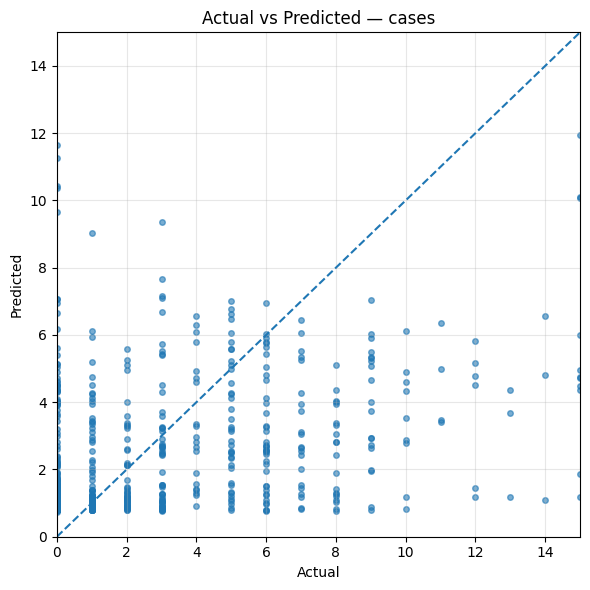

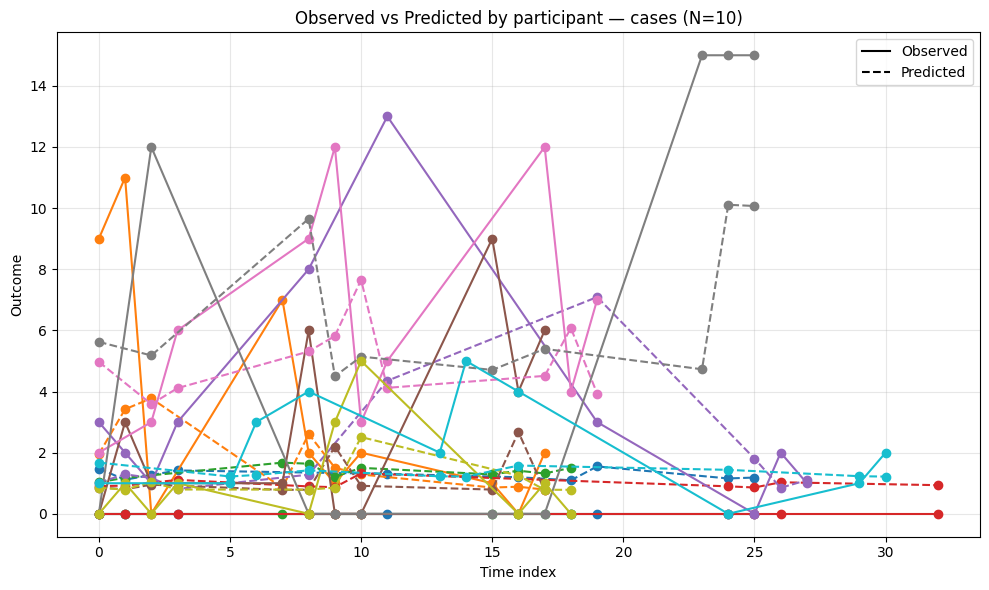

In [13]:
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

import numpy as np

# ---------- targets & aux ----------
y_raw      = EXP_reg_y.to_numpy(np.float32)
y_np       = y_raw if y_raw.ndim == 2 else y_raw.reshape(-1, 1)

y_lags_np  = EXP_reg_outcomes_lags.to_numpy(np.float32)
dt_lags_np = EXP_reg_forecast_horizons.to_numpy(np.float32)

# ---------- inputs ----------
# keep the two blocks SEPARATE; evaluator will:
#   - TC  <- only_fixed (after PCA)
#   - X_fix <- concat(only_fixed_PCA, fixed_and_random_PCA)
#   - Zrand <- fixed_and_random_PCA
X_only_fixed_np        = EXP_reg_only_fixed.to_numpy(np.float32)
X_fixed_and_random_np  = EXP_reg_fixed_and_random.to_numpy(np.float32)

# ---------- ids & time ----------
pid_raw    = EXP_reg_participant_id.to_numpy().ravel()
pid_uniqs, pid_encoded = np.unique(pid_raw, return_inverse=True)
pid_np     = pid_encoded.astype(np.int64)
n_ids      = int(len(pid_uniqs))

time_ix_np = EXP_reg_time.to_numpy().ravel()

def build_model_fn(
    *,
    y_dim: int,
    d_fix: int,
    d_tc: int,      # PCA(only_fixed)
    d_zrand: int,   # PCA(fixed_and_random)
    n_ids: int,
    **arch
):
    return KANAdditiveMixedEffects(
        y_dim=y_dim,
        d_fix=d_fix,     # concat(only_fixed_PCA, fixed_and_random_PCA)
        d_tc=d_tc,       # only_fixed_PCA -> FiLM
        d_zrand=d_zrand, # fixed_and_random_PCA -> random branch
        n_ids=n_ids,
        **arch
    )




arch_defaults = dict(d_fix_latent=256, d_rand_latent=256, n_kernels=16, dropout=0.0)
train_defaults = dict(
    lr=3e-3, weight_decay=1e-5, batch_size=64,
    max_epochs=100, patience=10, threshold=0.5,
    lambda_mean0=1e-5, lambda_ridge=1e-5,
    lambda_orth_latent=1e-5,
    lambda_film_identity=1e-5,
    lambda_kan=0,
    random_state=42,
    val_fraction=0.2, min_meas_test=3,
    loss="mse"
)

# =========================
# Run it (pick scenario and N)
# =========================
# Example 1: new-participant test
res_cases = evaluate_and_plot_single(scenario="cases", first_n=10)

# Example 2: time-split test (uncomment if you also want this)
# res_time  = evaluate_and_plot_single(scenario="time",  first_n=10)


In [ ]:
# =========================
# Add-on: build tidy test df, weekly error plots, residual diagnostics, save CSV
# =========================
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

def _week_rank_within_pid(pid: np.ndarray, time_ix: np.ndarray) -> np.ndarray:
    """
    Rank each row 1..n_i within participant by ascending time.
    Returns an array of the same length as pid/time_ix.
    """
    pid = np.asarray(pid)
    t   = np.asarray(time_ix)
    ranks = np.empty(len(pid), dtype=int)
    for p in np.unique(pid):
        idx = np.where(pid == p)[0]
        order = idx[np.argsort(t[idx])]
        ranks[order] = np.arange(1, len(order) + 1, dtype=int)
    return ranks

def build_test_dataframe(results: dict) -> pd.DataFrame:
    """
    results must be the dict returned by evaluate_and_plot_single().
    Produces a tidy DataFrame with per-row test info.
    """
    y_true = results["y_true_test"].ravel()
    y_pred = results["y_pred_test"].ravel()
    pid    = results["pid_test"].astype(int)
    timeix = results["time_test"]

    week_rank = _week_rank_within_pid(pid, timeix)
    df = pd.DataFrame({
        "pid": pid,
        "time_index": timeix,
        "week_rank": week_rank,
        "y_true": y_true,
        "y_pred": y_pred,
    })
    df["residual"] = df["y_pred"] - df["y_true"]
    return df

def plot_weekly_errors(df_test: pd.DataFrame, max_weeks: int = 20, title_prefix: str = ""):
    """
    Aggregates error over week_rank=1..max_weeks across participants and plots MAE & RMSE curves.
    """
    d = (
        df_test
        .loc[df_test["week_rank"] <= max_weeks]
        .copy()
    )
    grp = d.groupby("week_rank", as_index=False).agg(
        MAE=("residual", lambda r: float(np.mean(np.abs(r)))),
        RMSE=("residual", lambda r: float(np.sqrt(np.mean(np.square(r))))),
        n=("residual", "size"),
    )

    # MAE
    fig, ax = plt.subplots(figsize=(8,4))
    ax.plot(grp["week_rank"], grp["MAE"], "-o", linewidth=2)
    ax.set_xlabel("Week rank (within participant)")
    ax.set_ylabel("MAE")
    ax.set_title(f"{title_prefix} Weekly MAE (n per week varies)")
    ax.grid(True, alpha=0.3)
    plt.tight_layout(); plt.show()

    # RMSE
    fig, ax = plt.subplots(figsize=(8,4))
    ax.plot(grp["week_rank"], grp["RMSE"], "-o", linewidth=2)
    ax.set_xlabel("Week rank (within participant)")
    ax.set_ylabel("RMSE")
    ax.set_title(f"{title_prefix} Weekly RMSE (n per week varies)")
    ax.grid(True, alpha=0.3)
    plt.tight_layout(); plt.show()

    # Optional: sample size per week (can be handy)
    fig, ax = plt.subplots(figsize=(8,3))
    ax.bar(grp["week_rank"], grp["n"])
    ax.set_xlabel("Week rank")
    ax.set_ylabel("Count")
    ax.set_title(f"{title_prefix} Test rows per week")
    ax.grid(True, axis="y", alpha=0.3)
    plt.tight_layout(); plt.show()

def plot_residual_diagnostics(df_test: pd.DataFrame, title_prefix: str = ""):
    # Residuals histogram
    fig, ax = plt.subplots(figsize=(7,4))
    ax.hist(df_test["residual"], bins=40, alpha=0.8)
    ax.set_title(f"{title_prefix} Residuals histogram")
    ax.set_xlabel("Residual (y_pred - y_true)")
    ax.set_ylabel("Count")
    ax.grid(True, alpha=0.3)
    plt.tight_layout(); plt.show()

    # Residuals vs Fitted
    fig, ax = plt.subplots(figsize=(7,4))
    ax.scatter(df_test["y_pred"], df_test["residual"], s=12, alpha=0.6)
    ax.axhline(0.0, color="black", linestyle="--", linewidth=1)
    ax.set_title(f"{title_prefix} Residuals vs Predicted")
    ax.set_xlabel("Predicted")
    ax.set_ylabel("Residual")
    ax.grid(True, alpha=0.3)
    plt.tight_layout(); plt.show()

def save_test_csv(df_test: pd.DataFrame, path: str):
    df_test.to_csv(path, index=False)
    print(f"Saved: {path}")

# =========================
# Run the add-on for your two scenarios
# =========================

# (1) CASES scenario already ran in your previous call:
# res_cases = evaluate_and_plot_single(scenario="cases", first_n=10)

df_cases = build_test_dataframe(res_cases)
plot_weekly_errors(df_cases, max_weeks=20, title_prefix="[cases]")
plot_residual_diagnostics(df_cases, title_prefix="[cases]")
# save_test_csv(df_cases, "kan_cases_test_predictions.csv")

# (2) TIME scenario (uncomment to run a separate fit, then same analysis)
# res_time = evaluate_and_plot_single(scenario="time", first_n=10)
# df_time = build_test_dataframe(res_time)
# plot_weekly_errors(df_time, max_weeks=20, title_prefix="[time]")
# plot_residual_diagnostics(df_time, title_prefix="[time]")
# save_test_csv(df_time, "kan_time_test_predictions.csv")


### Simple cases split test

In [72]:
results = run_training_and_eval_kan(
    X_only_fixed_np, X_fixed_and_random_np, y_np, y_lags_np, dt_lags_np, pid_np, time_ix_np,
    build_model_fn=build_model_fn,
    wrapper_cls=KANMixedEffectsRegWrapper,
    mode="single",
    scenario="cases",
    train_defaults=train_defaults
)



Epoch 001 | train 13.396842 | val 10.651239
Epoch 002 | train 10.540825 | val 10.287268
Epoch 003 | train 9.591392 | val 9.838263
Epoch 004 | train 9.160029 | val 10.329488
Epoch 005 | train 7.787717 | val 11.320188
Epoch 006 | train 5.915417 | val 11.911542
Epoch 007 | train 4.604090 | val 12.951723
Epoch 008 | train 3.710806 | val 13.314583
Epoch 009 | train 3.165755 | val 13.397321
Epoch 010 | train 2.560015 | val 15.683063
Epoch 011 | train 2.171884 | val 12.801417
Epoch 012 | train 1.846762 | val 13.514762
Epoch 013 | train 1.642524 | val 13.121567
Early stopping at epoch 013 (best val 9.838263)

Single-fit test metrics:
       macro_MAE: 2.186242
       macro_MSE: 10.216752
  macro_PearsonR: 0.423506
        macro_R2: 0.158055
      macro_RMSE: 3.196365
task_1: MSE=10.216752, RMSE=3.196365, MAE=2.186242, R2=0.158055, PearsonR=0.423506


### Simple time split test

In [47]:
results = run_training_and_eval_kan(
    X_only_fixed_np, X_fixed_and_random_np, y_np, y_lags_np, dt_lags_np, pid_np, time_ix_np,
    build_model_fn=build_model_fn,
    wrapper_cls=KANMixedEffectsRegWrapper,
    mode="single",
    scenario="time",
    train_defaults=train_defaults,

)

Epoch 001 | train 15.191086 | val 10.176481
Epoch 002 | train 11.078441 | val 9.775215
Epoch 003 | train 10.360999 | val 9.474136
Epoch 004 | train 9.841178 | val 9.219025
Epoch 005 | train 8.132365 | val 9.806080
Epoch 006 | train 6.187256 | val 9.917340
Epoch 007 | train 4.364584 | val 11.813448
Epoch 008 | train 3.225908 | val 10.781802
Epoch 009 | train 2.544779 | val 11.750495
Epoch 010 | train 2.147396 | val 12.068660
Epoch 011 | train 1.714293 | val 11.302686
Epoch 012 | train 1.449885 | val 11.919052
Epoch 013 | train 1.283006 | val 11.595913
Epoch 014 | train 1.236620 | val 11.143318
Early stopping at epoch 014 (best val 9.219025)

Single-fit test metrics:
       macro_MAE: 2.200420
       macro_MSE: 10.739383
  macro_PearsonR: 0.594772
        macro_R2: 0.311435
      macro_RMSE: 3.277100
task_1: MSE=10.739383, RMSE=3.277100, MAE=2.200420, R2=0.311435, PearsonR=0.594772


### Cases split test CV without parameter search

In [42]:
results = run_training_and_eval_kan(
    X_only_fixed_np, X_fixed_and_random_np, y_np, y_lags_np, dt_lags_np, pid_np, time_ix_np,
    build_model_fn=build_model_fn,
    wrapper_cls=KANMixedEffectsRegWrapper,
    mode="cv_only",
    scenario="cases",
    arch_defaults=arch_defaults,
    train_defaults=train_defaults,
    outer_folds=5
)



Fold 1:

Per-fold test metrics:
       macro_MAE: 2.529446
       macro_MSE: 11.403911
  macro_PearsonR: 0.585850
        macro_R2: 0.314946
      macro_RMSE: 3.376968
task_1: MSE=11.403911, RMSE=3.376968, MAE=2.529446, R2=0.314946, PearsonR=0.585850

Fold 2:

Per-fold test metrics:
       macro_MAE: 2.665854
       macro_MSE: 12.105760
  macro_PearsonR: 0.694971
        macro_R2: 0.454990
      macro_RMSE: 3.479333
task_1: MSE=12.105760, RMSE=3.479333, MAE=2.665854, R2=0.454990, PearsonR=0.694971

Fold 3:

Per-fold test metrics:
       macro_MAE: 2.360177
       macro_MSE: 10.981968
  macro_PearsonR: 0.478410
        macro_R2: 0.213245
      macro_RMSE: 3.313905
task_1: MSE=10.981968, RMSE=3.313905, MAE=2.360177, R2=0.213245, PearsonR=0.478410

Fold 4:

Per-fold test metrics:
       macro_MAE: 2.485425
       macro_MSE: 11.500859
  macro_PearsonR: 0.522263
        macro_R2: 0.264160
      macro_RMSE: 3.391292
task_1: MSE=11.500859, RMSE=3.391292, MAE=2.485425, R2=0.264160, PearsonR=0

### Time split test CV without parameter search

In [ ]:
results = run_training_and_eval_kan(
    X_only_fixed_np, X_fixed_and_random_np, y_np, y_lags_np, dt_lags_np, pid_np, time_ix_np,
    build_model_fn=build_model_fn,
    wrapper_cls=KANMixedEffectsRegWrapper,
    mode="cv_only",
    scenario="time",
    arch_defaults=arch_defaults,
    train_defaults=train_defaults,
    outer_folds=5
)



Fold 1:

Per-fold test metrics:
       macro_MAE: 2.374766
       macro_MSE: 10.984379
  macro_PearsonR: 0.577343
        macro_R2: 0.331923
      macro_RMSE: 3.314269
task_1: MSE=10.984379, RMSE=3.314269, MAE=2.374766, R2=0.331923, PearsonR=0.577343

Fold 2:

Per-fold test metrics:
       macro_MAE: 2.419275
       macro_MSE: 11.041670
  macro_PearsonR: 0.607669
        macro_R2: 0.362640
      macro_RMSE: 3.322901
task_1: MSE=11.041670, RMSE=3.322901, MAE=2.419275, R2=0.362640, PearsonR=0.607669

Fold 3:

Per-fold test metrics:
       macro_MAE: 2.319470
       macro_MSE: 10.507090
  macro_PearsonR: 0.592105
        macro_R2: 0.346858
      macro_RMSE: 3.241464
task_1: MSE=10.507090, RMSE=3.241464, MAE=2.319470, R2=0.346858, PearsonR=0.592105

Fold 4:

Per-fold test metrics:
       macro_MAE: 2.160115
       macro_MSE: 9.371600
  macro_PearsonR: 0.596119
        macro_R2: 0.336463
      macro_RMSE: 3.061307
task_1: MSE=9.371600, RMSE=3.061307, MAE=2.160115, R2=0.336463, PearsonR=0.5

### Time split test CV WITH parameter search

In [ ]:
param_grid = {

    "d_fix_latent": [64, 128],
    "d_rand_latent": [64, 128],
    "n_kernels": [4, 8],
    "dropout": [0.0, 0.1, 0.2],

    "lr": [1e-3, 3e-4],
    "weight_decay": [0.0, 1e-4],
    "batch_size": [256],
    "max_epochs": [120],
    "patience": [12],
    "lambda_contrast": [1e-2, 5e-3, 2e-3],
    "contrast_temp": [0.2, 0.1],
    "lambda_orth": [1e-3, 5e-4],
    "lambda_mean0": [1e-3],
    "lambda_ridge": [1e-4, 5e-4],
    "lambda_kan": [0.0, 1e-4],
}

results = run_training_and_eval_kan(
    X_only_fixed_np, X_fixed_and_random_np, y_np, y_lags_np, dt_lags_np, pid_np, time_ix_np,
    build_model_fn=build_model_fn,
    wrapper_cls=KANMixedEffectsRegWrapper,
    mode="nested_cv",
    scenario="time",
    arch_defaults=arch_defaults,
    train_defaults=train_defaults,
    outer_folds=5,
    inner_folds=2,
    param_grid=param_grid,
)


Outer fold 1/5


### Cases split test CV WITH parameter search

In [ ]:
results = run_training_and_eval_kan(
    X_only_fixed_np, X_fixed_and_random_np, y_np, y_lags_np, dt_lags_np, pid_np, time_ix_np,
    build_model_fn=build_model_fn,
    wrapper_cls=KANMixedEffectsRegWrapper,
    mode="nested_cv",
    scenario="cases",
    arch_defaults=arch_defaults,
    train_defaults=train_defaults,
    outer_folds=5,
    inner_folds=2,
    param_grid=param_grid,
)

### Abblation

In [83]:
arch_defaults = dict(d_fix_latent=256, d_rand_latent=256, n_kernels=16, dropout=0.0, use_attention=True, use_random = False)

results = run_training_and_eval_kan(
    X_only_fixed_np, X_fixed_and_random_np, y_np, y_lags_np, dt_lags_np, pid_np, time_ix_np,
    build_model_fn=build_model_fn,
    wrapper_cls=KANMixedEffectsRegWrapper,
    mode="cv_only",
    scenario="cases",
    arch_defaults=arch_defaults,
    train_defaults=train_defaults,
    outer_folds=5
)



Fold 1:

Per-fold test metrics:
       macro_MAE: 2.388597
       macro_MSE: 11.249486
  macro_PearsonR: 0.570898
        macro_R2: 0.324222
      macro_RMSE: 3.354025
task_1: MSE=11.249486, RMSE=3.354025, MAE=2.388597, R2=0.324222, PearsonR=0.570898

Fold 2:

Per-fold test metrics:
       macro_MAE: 2.668198
       macro_MSE: 12.413414
  macro_PearsonR: 0.707859
        macro_R2: 0.441139
      macro_RMSE: 3.523268
task_1: MSE=12.413414, RMSE=3.523268, MAE=2.668198, R2=0.441139, PearsonR=0.707859

Fold 3:

Per-fold test metrics:
       macro_MAE: 2.338246
       macro_MSE: 11.083455
  macro_PearsonR: 0.481935
        macro_R2: 0.205974
      macro_RMSE: 3.329182
task_1: MSE=11.083455, RMSE=3.329182, MAE=2.338246, R2=0.205974, PearsonR=0.481935

Fold 4:

Per-fold test metrics:
       macro_MAE: 2.424448
       macro_MSE: 11.718911
  macro_PearsonR: 0.504823
        macro_R2: 0.250208
      macro_RMSE: 3.423290
task_1: MSE=11.718911, RMSE=3.423290, MAE=2.424448, R2=0.250208, PearsonR=0

In [80]:
arch_defaults = dict(d_fix_latent=256, d_rand_latent=256, n_kernels=16, dropout=0.0, use_attention=False, use_random = True)

results = run_training_and_eval_kan(
    X_only_fixed_np, X_fixed_and_random_np, y_np, y_lags_np, dt_lags_np, pid_np, time_ix_np,
    build_model_fn=build_model_fn,
    wrapper_cls=KANMixedEffectsRegWrapper,
    mode="cv_only",
    scenario="time",
    arch_defaults=arch_defaults,
    train_defaults=train_defaults,
    outer_folds=5
)



Fold 1:

Per-fold test metrics:
       macro_MAE: 2.323098
       macro_MSE: 11.131522
  macro_PearsonR: 0.571979
        macro_R2: 0.322973
      macro_RMSE: 3.336394
task_1: MSE=11.131522, RMSE=3.336394, MAE=2.323098, R2=0.322973, PearsonR=0.571979

Fold 2:

Per-fold test metrics:
       macro_MAE: 2.363097
       macro_MSE: 11.013583
  macro_PearsonR: 0.605279
        macro_R2: 0.364261
      macro_RMSE: 3.318672
task_1: MSE=11.013583, RMSE=3.318672, MAE=2.363097, R2=0.364261, PearsonR=0.605279

Fold 3:

Per-fold test metrics:
       macro_MAE: 2.250372
       macro_MSE: 10.605227
  macro_PearsonR: 0.592987
        macro_R2: 0.340757
      macro_RMSE: 3.256567
task_1: MSE=10.605227, RMSE=3.256567, MAE=2.250372, R2=0.340757, PearsonR=0.592987

Fold 4:

Per-fold test metrics:
       macro_MAE: 2.120395
       macro_MSE: 9.421944
  macro_PearsonR: 0.583765
        macro_R2: 0.332899
      macro_RMSE: 3.069518
task_1: MSE=9.421944, RMSE=3.069518, MAE=2.120395, R2=0.332899, PearsonR=0.5